In [2]:
from numpy import arange, exp, convolve, roll, zeros, corrcoef, array
from numpy.random import randint, poisson
from scipy.signal import correlate
from matplotlib.pyplot import plot, subplot, figure, title, legend, xlabel, ylabel, axis, xlim, ylim, axvline, xticks
from scipy import interpolate

%matplotlib inline

### First define functions necessary for generating data and performing slice time correction

In [8]:
def spikingResponse(stim):
    # take a vector of probabilities, and return a vector of values sampled from [0,1] 
    # with probabilities given by input vector

    from numpy import zeros
    from numpy.random import choice
    
    response = zeros(stim.shape)
    for ind,x in enumerate(stim):
        response[ind] = choice([0,1], p = [1 - x, x])
    
    return response

In [9]:
def shiftData(vec, shiftTs):
    # take a vector and an array of timepoints and use cubic spline interpolation to 
    # resample the vector at those timepoints
    
    from numpy import arange
    from scipy import interpolate
    
    interval = arange(len(vec))
    interpFun = interpolate.interp1d(interval, vec, 'cubic')
    return interpFun(shiftTs)

In [162]:
def getSliceShifts(exposure, num_planes, interstack):
    # Given exposure, number of planes, and time between stacks, return a list of time shifts required
    # to perform slice time correction
    
    from numpy import arange
    
    # get the duration of a single stack
    stack_dur = exposure * num_planes
    
    # generate a sequence of negative floats with length equal to the number of planes.      
    shifts = -arange(num_planes, dtype='float')
    
    # center the values around 0
    shifts += ((num_planes - 1) / 2.0)
    
    # rescale the values into frame time
    shifts *= float(exposure) / (stack_dur + interstack)
    
    return shifts

In [169]:
def recordData(dat, expr, interstack):
    # Sequentially subsample a matrix of fake signals
    
    from numpy import arange, zeros
    
    z = dat.shape[1]
    
    ds = z * expr + interstack    
    tr = arange(0, z * expr, expr)

    samptimes = [range(t, dat.shape[0], ds) for t in tr]
    
    # trim off sample times for partial stacks
    for ind, val in enumerate(samptimes):
        samptimes[ind] = val[0:len(samptimes[-1])]
    
    rec = zeros([len(samptimes[-1]), z])
    for curz in range(z):
        rec[:, curz] = dat[:, curz][samptimes[curz]]
    
    return rec, samptimes

### Generate a kernel for our fluorescent indicator

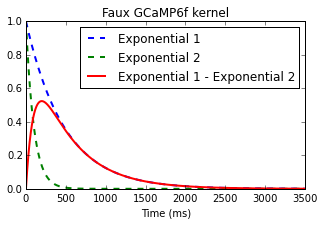

In [171]:
taus = [-480.0, -100.0]
base = arange(0,3500.0)
kern = exp(base/taus[0])  -  exp(base/taus[1])

figure(figsize=(5,3))
plot(exp(base/taus[0]),'--', linewidth=2,label='Exponential 1')
plot(exp(base/taus[1]),'--',linewidth=2, label='Exponential 2')
plot(kern,linewidth=2, label='Exponential 1 - Exponential 2')
title('Faux GCaMP6f kernel')
legend()
xlabel('Time (ms)')

### Generate a spike train and convolve it with our kernel 

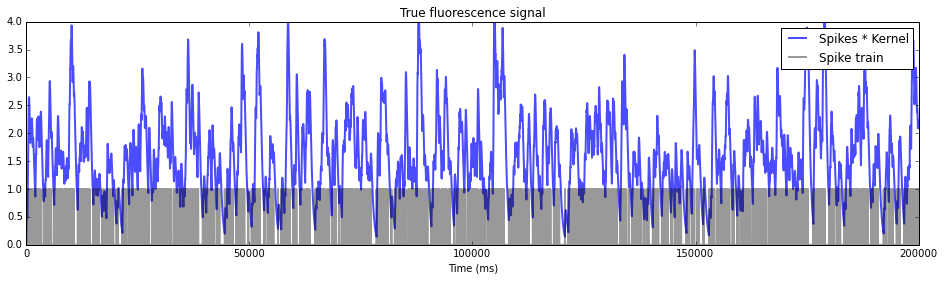

In [172]:
trange = 200000
spike_rate = 4
stim = (spike_rate / 1000.0) + zeros(trange)
spikes = spikingResponse(stim)  
truesig = convolve(spikes,kern, mode='full')[0:trange]

figure(figsize=(16, 4))
ax1 = subplot(111)
plot(truesig, 'b', label = 'Spikes * Kernel', linewidth = 2, alpha = .7)
plot(spikes, 'k', label = 'Spike train', linewidth = 2, alpha = .4)
axis('tight')
ylim(0, 4)
xlabel('Time (ms)')
legend()
title('True fluorescence signal')

### Sample fake data, then correct for slice timing by interpolation

In [176]:
# Number of planes in our "stack"
z = 50
dims = [z, trange]

# The value we use as baseline for calculating df/f
baseline = 100.0

# This value is multiplied against the fluorescence trace before detrending
sigmag = 100.0

# The magnitude of the poisson noise added to each plane
noisemag = 1

# Z positions of source 1 and source 2
srce1z = [0, 3]
srce2z = [z - 3, z]
# Shift in ms source 1 relative to source 2
srceshift = 0
srce1 = truesig.T

# Apply shift
srce2 = roll(truesig.T, srceshift, 0)

# Data starts as noise scaled by noisemag
data = poisson(baseline, [dims[0], dims[1]]) * noisemag

# Add the source vectors to the correct z locations
data[srce1z[0]:srce1z[-1]] += srce1 * sigmag
data[srce2z[0]:srce2z[-1]] += srce2 * sigmag

# Compute df/f
data = (data.T - baseline) / baseline

# Exposure, in ms
expr = 8

# Interstack interval, in ms
interstack = 100

# The total time for each stack
ds = z * expr + interstack

# Stack rate, in Hz
fps = 1000.0 / ds

# The sample times for the first plane in the stack
tr = arange(0, z * expr, expr)

# Generate sampled data and the sample times
rec, samptimes = recordData(data, expr, interstack)

# Get the resample times for each plane
shifts = getSliceShifts(expr, z, interstack)

# Initialize the data array for the interpolated data
shifted = zeros([rec.shape[0] - 2, rec.shape[1]])

# Interpolate each z plane according to how far it is from the center plane
for curz in range(z):
    shifted[:, curz] = shiftData(rec[:, curz], arange(1, rec.shape[0] - 1) + shifts[curz])

# Calculate cross-correlation between signals

# xcorr between separated signals under raw sampling
xcRaw = correlate(rec[1:-1, 0:3].mean(1), rec[1:-1, -3:].mean(1), mode = 'same')
# xcorr between separated signals under interpolated sampling
xcInterp = correlate(shifted[:, 0:3].mean(1), shifted[:, -3:].mean(1), mode = 'same')
# xcorr between separated signals under perfect sampling (0 timelag)
xcIdeal = correlate(data[samptimes[0][1:-1], 0:3].mean(1), data[samptimes[0][1:-1], -3:].mean(1), mode='same')

### Plot results of slice-time correction

Num planes: 50
Frame rate: 2.0 Hz


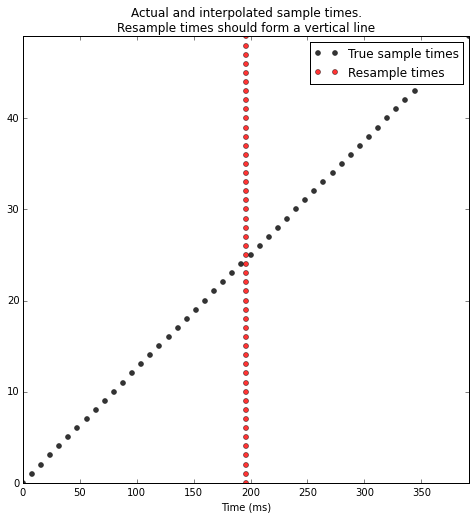

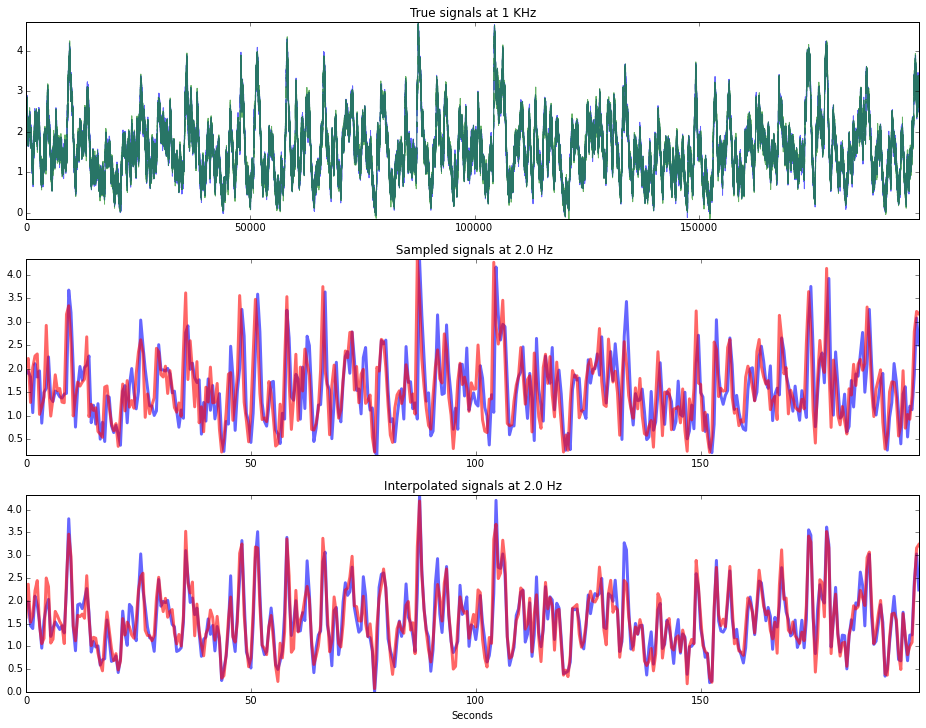

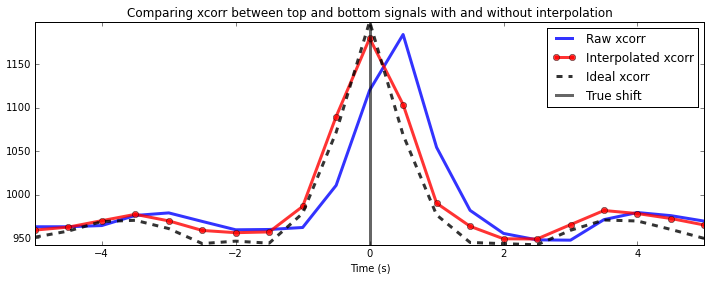

In [174]:
# Plot the original sample times and the resample times
figure(figsize = (8, 8))
subplot(111)

for ind, p in enumerate(range(z)):
    offset = ind * plscale    
    p1, = plot(samptimes[ind][:1], ind, 'ko', markersize=5, alpha = .8, label = 'True sample times')
    p2, = plot(samptimes[ind][:1] + shifts[p] * ds, ind, 'ro', markersize=5, alpha = .8, label = 'Resample times')
axis('tight')
title('Actual and interpolated sample times.\nResample times should form a vertical line')
xlabel('Time (ms)')
legend(handles = [p1,p2])

print('Num planes: {0}'.format(z))
print('Frame rate: {0:.1f} Hz'.format(fps))    

# Plot the true signals, the sampled signals, and the interpolated signals 
figure(figsize=(16, 12))
subplot(311)

plot(data[ds:-ds, 0], alpha = .6)
plot(data[ds:-ds, -1], alpha = .6)
title('True signals at 1 KHz')
axis('tight')

subplot(312)
plot(arange(rec.shape[0]-2) / float(fps), rec[1:-1, 0:3].mean(1), 'b', alpha = .6, linewidth = 3)
plot(arange(rec.shape[0]-2) / float(fps), rec[1:-1, -3:].mean(1), 'r', alpha = .6, linewidth = 3)
title(' Sampled signals at {0:.1f} Hz'.format(fps))
axis('tight')

subplot(313)
plot(arange(shifted.shape[0]) / float(fps), shifted[:, 0:3].mean(1), 'b', alpha = .6, linewidth = 3)
plot(arange(shifted.shape[0]) / float(fps), shifted[:, -3:].mean(1), 'r', alpha = .6, linewidth = 3)
xlabel('Seconds')

title('Interpolated signals at {0:.1f} Hz'.format(fps))
axis('tight')

figure(figsize=(12, 4))
subplot(111)

plr = arange(-10,11) + xcIdeal.shape[0] / 2 
xscale = (plr - xcIdeal.shape[0] / 2) /float(fps)

plot(xscale, xcRaw[plr], linewidth = 3, label = 'Raw xcorr', alpha = .8)
plot(xscale, xcInterp[plr], 'r-o', linewidth = 3, label = 'Interpolated xcorr', alpha = .8)
plot(xscale, xcIdeal[plr], 'k--', linewidth = 3, label = 'Ideal xcorr', alpha =.8)
axvline(-srceshift / float(1000), linewidth = 3, alpha = .6, label = 'True shift', color = 'k')
xlabel('Time (s)')
legend()
axis('tight')
title('Comparing xcorr between top and bottom signals with and without interpolation')